## Artigo Original: https://arxiv.org/abs/1906.05272

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%cd drive/MyDrive

/content/drive/MyDrive


In [3]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

import torch.utils.data
import math


class LayerNorm(nn.Module):
    """
    layer normalization
    Simple layer norm object optionally used with the convolutional encoder.
    """

    def __init__(self, feature_dim, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones((feature_dim,)))
        self.register_parameter("gamma", self.gamma)
        self.beta = nn.Parameter(torch.zeros((feature_dim,)))
        self.register_parameter("beta", self.beta)
        self.eps = eps

    def forward(self, x):
        # x: [batch_size, embed_dim]
        # normalize for each embedding
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # output shape is the same as x
        # Type not match for self.gamma and self.beta??????????????????????
        # output: [batch_size, embed_dim]
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


def get_activation_function(activation, context_str):
    if activation == "leakyrelu":
        return nn.LeakyReLU(negative_slope=0.2)
    elif activation == "relu":
        return nn.ReLU()
    elif activation == "sigmoid":
        return nn.Sigmoid()
    elif activation == 'tanh':
        return nn.Tanh()
    elif activation == 'gelu':
        return nn.GELU()
    else:
        raise Exception("{} activation not recognized.".format(context_str))


class SingleFeedForwardNN(nn.Module):
    """
        Creates a single layer fully connected feed forward neural network.
        this will use non-linearity, layer normalization, dropout
        this is for the hidden layer, not the last layer of the feed forard NN
    """

    def __init__(self, input_dim,
                 output_dim,
                 dropout_rate=None,
                 activation="sigmoid",
                 use_layernormalize=False,
                 skip_connection=False,
                 context_str=''):
        '''

        Args:
            input_dim (int32): the input embedding dim
            output_dim (int32): dimension of the output of the network.
            dropout_rate (scalar tensor or float): Dropout keep prob.
            activation (string): tanh or relu or leakyrelu or sigmoid
            use_layernormalize (bool): do layer normalization or not
            skip_connection (bool): do skip connection or not
            context_str (string): indicate which spatial relation encoder is using the current FFN

        '''
        super(SingleFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        if dropout_rate is not None:
            self.dropout = nn.Dropout(p=dropout_rate)
        else:
            self.dropout = None

        self.act = get_activation_function(activation, context_str)

        if use_layernormalize:
            # the layer normalization is only used in the hidden layer, not the last layer
            self.layernorm = nn.LayerNorm(self.output_dim)
        else:
            self.layernorm = None

        # the skip connection is only possible, if the input and out dimention is the same
        if self.input_dim == self.output_dim:
            self.skip_connection = skip_connection
        else:
            self.skip_connection = False

        self.linear = nn.Linear(self.input_dim, self.output_dim)
        nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size,..., output_dim]
            note there is no non-linearity applied to the output.

        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        assert input_tensor.size()[-1] == self.input_dim
        # Linear layer
        output = self.linear(input_tensor)
        # non-linearity
        output = self.act(output)
        # dropout
        if self.dropout is not None:
            output = self.dropout(output)

        # skip connection
        if self.skip_connection:
            output = output + input_tensor

        # layer normalization
        if self.layernorm is not None:
            output = self.layernorm(output)

        return output


class MultiLayerFeedForwardNN(nn.Module):
    """
        Creates a fully connected feed forward neural network.
        N fully connected feed forward NN, each hidden layer will use non-linearity, layer normalization, dropout
        The last layer do not have any of these
    """

    def __init__(self, input_dim,
                 output_dim,
                 num_hidden_layers=0,
                 dropout_rate=None,
                 hidden_dim=-1,
                 activation="sigmoid",
                 use_layernormalize=False,
                 skip_connection=False,
                 context_str=None):
        '''

        Args:
            input_dim (int32): the input embedding dim
            num_hidden_layers (int32): number of hidden layers in the network, set to 0 for a linear network.
            output_dim (int32): dimension of the output of the network.
            dropout (scalar tensor or float): Dropout keep prob.
            hidden_dim (int32): size of the hidden layers
            activation (string): tanh or relu
            use_layernormalize (bool): do layer normalization or not
            context_str (string): indicate which spatial relation encoder is using the current FFN

        '''
        super(MultiLayerFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_hidden_layers = num_hidden_layers
        self.dropout_rate = dropout_rate
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.use_layernormalize = use_layernormalize
        self.skip_connection = skip_connection
        self.context_str = context_str

        self.layers = nn.ModuleList()
        if self.num_hidden_layers <= 0:
            self.layers.append(SingleFeedForwardNN(input_dim=self.input_dim,
                                                   output_dim=self.output_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=False,
                                                   skip_connection=False,
                                                   context_str=self.context_str))
        else:
            self.layers.append(SingleFeedForwardNN(input_dim=self.input_dim,
                                                   output_dim=self.hidden_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=self.use_layernormalize,
                                                   skip_connection=self.skip_connection,
                                                   context_str=self.context_str))

            for i in range(self.num_hidden_layers - 1):
                self.layers.append(SingleFeedForwardNN(input_dim=self.hidden_dim,
                                                       output_dim=self.hidden_dim,
                                                       dropout_rate=self.dropout_rate,
                                                       activation=self.activation,
                                                       use_layernormalize=self.use_layernormalize,
                                                       skip_connection=self.skip_connection,
                                                       context_str=self.context_str))

            self.layers.append(SingleFeedForwardNN(input_dim=self.hidden_dim,
                                                   output_dim=self.output_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=False,
                                                   skip_connection=False,
                                                   context_str=self.context_str))

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size, ..., output_dim]
            note there is no non-linearity applied to the output.

        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        assert input_tensor.size()[-1] == self.input_dim
        output = input_tensor
        for i in range(len(self.layers)):
            output = self.layers[i](output)

        return output

In [5]:
import torch
import torch.nn as nn
import numpy as np

class WrapPositionEncoder(nn.Module):
    """
    Realiza a codificação 'Wrap' para lidar com a periodicidade da Terra.
    Transforma (Lat, Lon) em componentes trigonométricos.
    """
    def __init__(self, device='cuda'):
        super().__init__()
        self.device = device

    def forward(self, coords):
        """
        Entrada: [batch_size, 2] (Lat, Lon em graus)
        Saída:   [batch_size, 4] (cos(lat), sin(lat), cos(lon), sin(lon))
        """
        if not torch.is_tensor(coords):
            coords = torch.tensor(coords, dtype=torch.float32).to(self.device)
        else:
            coords = coords.float().to(self.device)

        lat = coords[..., 0]
        lon = coords[..., 1]

        lat_rad = torch.deg2rad(lat)
        lon_rad = torch.deg2rad(lon)

        v1 = torch.cos(lat_rad)
        v2 = torch.sin(lat_rad)
        v3 = torch.cos(lon_rad)
        v4 = torch.sin(lon_rad)

        return torch.stack([v1, v2, v3, v4], dim=-1)

class WrapLocationEncoder(nn.Module):
    """
    Encoder completo estilo 'Wrap'.
    Substitui o GridLookupSpatialRelationLocationEncoder.
    """
    def __init__(
        self,
        spa_embed_dim=64,
        extent=None,
        interval=None,
        input_dim=4,
        ffn_num_hidden_layers=1,
        ffn_dropout_rate=0.5,
        ffn_hidden_dim=256,
        ffn_act="relu",
        ffn_use_layernormalize=True,
        ffn_skip_connection=True,
        device="cuda"
    ):
        super().__init__()
        self.device = device

        self.position_encoder = WrapPositionEncoder(device=device)


        self.input_projector = nn.Linear(input_dim, ffn_hidden_dim)

        self.ffn = MultiLayerFeedForwardNN(
            input_dim=ffn_hidden_dim,
            output_dim=spa_embed_dim,
            num_hidden_layers=ffn_num_hidden_layers,
            dropout_rate=ffn_dropout_rate,
            hidden_dim=ffn_hidden_dim,
            activation=ffn_act,
            use_layernormalize=ffn_use_layernormalize,
            skip_connection=ffn_skip_connection,
            context_str="WrapEncoder"
        )

    def forward(self, coords):
        feat = self.position_encoder(coords)

        feat = self.input_projector(feat)

        out = self.ffn(feat)

        return out

In [7]:
ESTADO = "Alaska"

In [8]:
import pandas as pd

checkins = pd.read_csv(f'/content/drive/MyDrive/Checkins_MTLPoi/separated/checkins_{ESTADO.title()}.csv')[['latitude', 'longitude', 'category','placeid']]
coords = np.stack([checkins['latitude'], checkins['longitude']], axis=1)
categories = checkins[['category']].values
placeid = checkins[['placeid']].values

In [9]:
class WrapLocationContrastiveModel(nn.Module):
    def __init__(self, embed_dim=64):
        super().__init__()

        self.encoder = WrapLocationEncoder(
            spa_embed_dim=128,
            ffn_hidden_dim=256,
            ffn_num_hidden_layers=2,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )

        self.projector = nn.Linear(128, embed_dim)

    def forward(self, coords):
        z = self.encoder(coords)
        z = self.projector(z)
        return torch.nn.functional.normalize(z, dim=-1)

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ContrastiveSpatialDataset(Dataset):
    def __init__(self, coords, pos_radius=0.01):
        """
        Args:
            coords: Array numpy ou Tensor [N, 2] com todas as coordenadas (Lat, Lon).
            pos_radius: Raio (em graus) para considerar um ponto como "vizinho" (positivo).
                        0.01 graus é aprox 1.1km.
        """
        self.coords = coords
        self.num_points = len(coords)
        self.pos_radius = pos_radius

    def __len__(self):
        return self.num_points

    def __getitem__(self, idx):
        coord_i = self.coords[idx]

        if np.random.random() > 0.5:
            label = 1.0

            noise = np.random.normal(0, self.pos_radius, size=2)
            coord_j = coord_i + noise

        else:
            label = 0.0

            rand_idx = np.random.randint(0, self.num_points)
            coord_j = self.coords[rand_idx]

        return (
            torch.tensor(coord_i, dtype=torch.float32),
            torch.tensor(coord_j, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32)
        )

In [13]:
dataset = ContrastiveSpatialDataset(coords, pos_radius=0.01)

loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

print(f"Total de batches por época: {len(loader)}")

sample_i, sample_j, sample_lbl = next(iter(loader))
print("\nExemplo de saída do Loader:")
print(f"Coord A (Shape): {sample_i.shape}")
print(f"Coord B (Shape): {sample_j.shape}")
print(f"Labels (Exemplo): {sample_lbl[:5]}")

Total de batches por época: 425

Exemplo de saída do Loader:
Coord A (Shape): torch.Size([64, 2])
Coord B (Shape): torch.Size([64, 2])
Labels (Exemplo): tensor([0., 1., 1., 0., 0.])


In [14]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

In [15]:
!pip install "sympy==1.12"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 56.1 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cpu requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = WrapLocationContrastiveModel(embed_dim=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
def contrastive_bce(z_i, z_j, label, tau=0.1):
    sim = F.cosine_similarity(z_i, z_j)
    logits = sim / tau
    targets = label.float().to(z_i.device)
    return F.binary_cross_entropy_with_logits(logits, targets)

for epoch in range(50):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for coord_i, coord_j, label in loader:
        ci = coord_i.float().to(device)
        cj = coord_j.float().to(device)
        label = label.to(device)

        z_i = model(ci)
        z_j = model(cj)

        loss = contrastive_bce(z_i, z_j, label, tau=0.15)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    print(f"Epoch {epoch+1}: Loss = {total_loss/n_batches:.4f}")

Epoch 1: Loss = 0.8406
Epoch 2: Loss = 0.8219
Epoch 3: Loss = 0.8140
Epoch 4: Loss = 0.8099
Epoch 5: Loss = 0.8079
Epoch 6: Loss = 0.8045
Epoch 7: Loss = 0.8045
Epoch 8: Loss = 0.7976
Epoch 9: Loss = 0.7974
Epoch 10: Loss = 0.7927
Epoch 11: Loss = 0.7955
Epoch 12: Loss = 0.7925
Epoch 13: Loss = 0.7993
Epoch 14: Loss = 0.7925
Epoch 15: Loss = 0.7951
Epoch 16: Loss = 0.7903
Epoch 17: Loss = 0.7900
Epoch 18: Loss = 0.8007
Epoch 19: Loss = 0.7875
Epoch 20: Loss = 0.7900
Epoch 21: Loss = 0.7942
Epoch 22: Loss = 0.7891
Epoch 23: Loss = 0.7895
Epoch 24: Loss = 0.7942
Epoch 25: Loss = 0.7908
Epoch 26: Loss = 0.7882
Epoch 27: Loss = 0.7894
Epoch 28: Loss = 0.7851
Epoch 29: Loss = 0.7892
Epoch 30: Loss = 0.7924
Epoch 31: Loss = 0.7880
Epoch 32: Loss = 0.7889
Epoch 33: Loss = 0.7878
Epoch 34: Loss = 0.7907
Epoch 35: Loss = 0.7860
Epoch 36: Loss = 0.7921
Epoch 37: Loss = 0.7874
Epoch 38: Loss = 0.7841
Epoch 39: Loss = 0.7843
Epoch 40: Loss = 0.7880
Epoch 41: Loss = 0.7882
Epoch 42: Loss = 0.7841
E

In [18]:
loc_embeds = model(torch.Tensor(coords))

loc_embeds

tensor([[-0.0431,  0.1331,  0.0073,  ..., -0.0609,  0.1367, -0.2356],
        [ 0.0694,  0.0292,  0.0841,  ..., -0.0081,  0.0368, -0.1169],
        [-0.0283, -0.2017, -0.2123,  ..., -0.1607, -0.0723, -0.1927],
        ...,
        [-0.1537,  0.0076,  0.2162,  ..., -0.0245, -0.1561, -0.1522],
        [-0.0744, -0.1465, -0.0967,  ...,  0.0718, -0.0595,  0.0914],
        [-0.2025, -0.0081,  0.1080,  ...,  0.1820, -0.1214,  0.0391]],
       grad_fn=<DivBackward0>)

In [19]:
loc_embeds = loc_embeds.detach().numpy()

In [21]:
import pandas as pd
import numpy as np
import torch
import os
folder_path = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/wrap/"
if not os.path.exists(folder_path):
  os.makedirs(folder_path)

emb_np = loc_embeds
n_embeds = emb_np.shape[1]
embed_cols = [f"{i}" for i in range(n_embeds)]

placeid_arr   = np.asarray(placeid).reshape(-1)
category_arr  = np.asarray(categories).reshape(-1)

if emb_np.shape[0] != len(placeid_arr):
    raise ValueError(f"loc_embeds tem {emb_np.shape[0]} linhas, "
                     f"mas placeid tem {len(placeid_arr)} elementos.")

df_location_embeddings = pd.DataFrame(emb_np, columns=embed_cols)
df_location_embeddings.insert(0, "placeid", placeid_arr.astype(str))
df_location_embeddings["category"] = category_arr.astype(str)

print("df_location_embeddings (check-in level):", df_location_embeddings.shape)

df_mean_embeds = (
    df_location_embeddings
    .groupby("placeid")[embed_cols]
    .mean()
    .reset_index()
)

df_mode_cat = (
    df_location_embeddings
    .groupby("placeid")["category"]
    .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    .reset_index()
)

df_final = df_mean_embeds.merge(df_mode_cat, on="placeid")

print("df_final (POI-level):", df_final.shape)

out_path = f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/wrap/location_encoder_embeddings-{ESTADO.lower()}.csv"
df_final.to_csv(out_path, index=False)
df_final.head()


df_location_embeddings (check-in level): (27258, 66)
df_final (POI-level): (2740, 66)


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,1000487,-0.017721,-0.016457,-0.013485,0.020968,0.043582,-0.031765,-0.058520,0.082747,-0.018624,...,0.011848,-0.116486,-0.005698,-0.030775,0.035410,-0.079162,-0.012194,0.021657,-0.016902,Shopping
1,1001578,-0.003344,0.045925,0.030119,-0.047194,-0.004642,-0.010657,0.004264,0.054790,-0.074403,...,-0.044954,0.057456,0.046585,-0.104224,0.015958,-0.016685,-0.073117,-0.067745,-0.002621,Food
2,1008534,-0.041206,0.047236,-0.020887,-0.007633,-0.004830,-0.062659,0.029214,-0.016035,-0.100137,...,0.024597,-0.030763,0.041631,-0.065722,0.024683,0.025249,-0.001765,0.020792,-0.006466,Entertainment
3,1008890,-0.026382,0.029505,-0.001449,-0.026033,-0.039013,-0.101758,0.019651,0.072932,-0.037234,...,0.038637,-0.012081,0.017507,-0.086079,0.070442,-0.038272,-0.024287,0.037079,0.007280,Shopping
4,1010345,-0.054750,0.007923,-0.056237,-0.030745,-0.058718,-0.147271,-0.081238,-0.021043,-0.097289,...,-0.041995,-0.031146,0.053092,-0.211663,0.037448,0.031323,0.088071,-0.062747,-0.032846,Community


In [22]:
df = pd.read_csv(f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/wrap/location_encoder_embeddings-{ESTADO.lower()}.csv")
placeids = df["placeid"].astype(str).tolist()
E = df[[c for c in df.columns if c.isnumeric()]].to_numpy(dtype=np.float32)

torch.save({
    "embeddings": torch.from_numpy(E),
    "placeids": placeids
}, f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/wrap/poi_embeddings_location-{ESTADO.lower()}.pt")


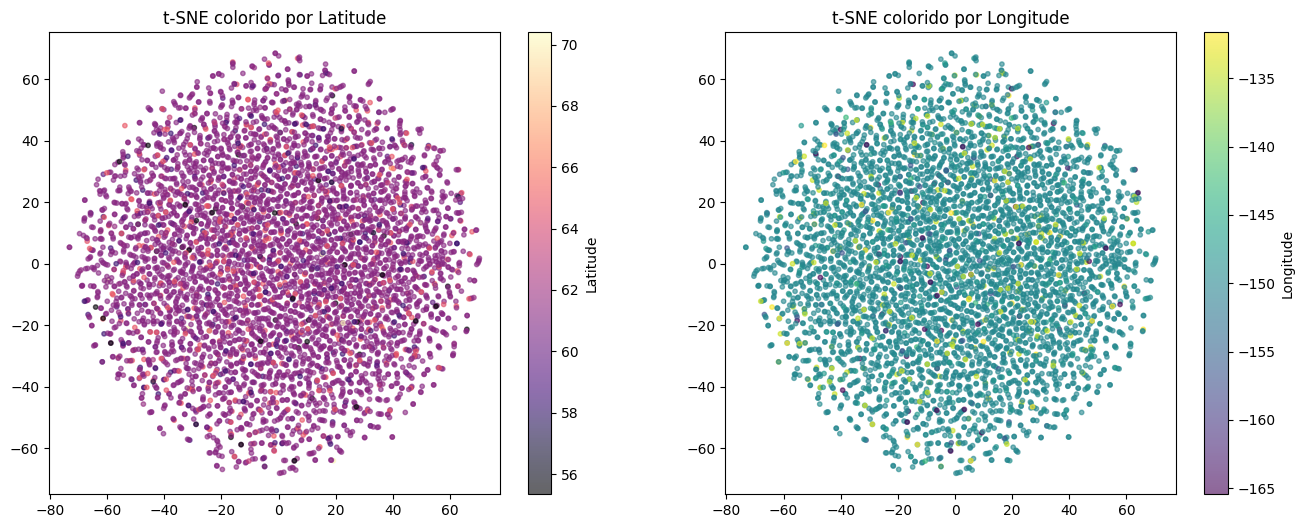

In [23]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

n_samples = 5000
indices = np.random.choice(len(loc_embeds), n_samples, replace=False)

subset_embeds = loc_embeds[indices]
subset_coords = coords[indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeds_2d = tsne.fit_transform(subset_embeds)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sc1 = ax[0].scatter(embeds_2d[:, 0], embeds_2d[:, 1],
                    c=subset_coords[:, 0], cmap='magma', s=10, alpha=0.6)
ax[0].set_title("t-SNE colorido por Latitude")
plt.colorbar(sc1, ax=ax[0], label='Latitude')

sc2 = ax[1].scatter(embeds_2d[:, 0], embeds_2d[:, 1],
                    c=subset_coords[:, 1], cmap='viridis', s=10, alpha=0.6)
ax[1].set_title("t-SNE colorido por Longitude")
plt.colorbar(sc2, ax=ax[1], label='Longitude')

plt.show()